In [1]:
import numpy as np
import scipy.sparse as sp
from collections import Counter
import math
from torch.nn.utils.rnn import pad_sequence

class BM25:
    def __init__(self, documents, k1=1.5, b=0.75):
        self.documents = documents
        self.k1 = k1
        self.b = b
        self.doc_len = np.array([len(doc) for doc in documents])
        self.avgdl = np.mean(self.doc_len)
        self.term_frequency, self.document_frequency = self._compute_frequencies()

    def _compute_frequencies(self):
        term_frequency = []
        document_frequency = Counter()
        for doc in self.documents:
            tf = Counter(doc)
            term_frequency.append(tf)
            document_frequency.update(tf.keys())
        
        # Convert term frequency to sparse matrix format
        vocab = {term: idx for idx, term in enumerate(document_frequency.keys())}
        rows, cols, data = [], [], []
        for doc_idx, tf in enumerate(term_frequency):
            for term, freq in tf.items():
                rows.append(doc_idx)
                cols.append(vocab[term])
                data.append(freq)
        
        term_frequency_matrix = sp.csr_matrix((data, (rows, cols)), shape=(len(self.documents), len(vocab)))
        return term_frequency_matrix, document_frequency

    def _idf(self, term):
        df = self.document_frequency[term]
        return math.log((len(self.documents) - df + 0.5) / (df + 0.5) + 1)

    def _compute_scores(self, query_terms):
        vocab = {term: idx for idx, term in enumerate(self.document_frequency.keys())}
        query_term_indices = [vocab[term] for term in query_terms if term in vocab]
        
        # Compute IDF for query terms
        idf = np.array([self._idf(term) for term in query_terms if term in vocab])
        
        # Get the relevant columns for the query terms
        tf = self.term_frequency[:, query_term_indices].toarray()
        
        # Compute BM25 score
        numerator = tf * (self.k1 + 1)
        denominator = tf + self.k1 * (1 - self.b + self.b * self.doc_len[:, None] / self.avgdl)
        scores = (idf * numerator / denominator).sum(axis=1)
        return scores

    def search(self, query, top_n=10):
        query_terms = query.split()
        scores = self._compute_scores(query_terms)
        top_indices = np.argsort(scores)[::-1][:top_n]
        return top_indices, scores[top_indices]

# Sample usage
documents = [
    ["the", "cat", "in", "the", "hat"],
    ["the", "quick", "brown", "fox"],
    ["jumps", "over", "the", "lazy", "dog"]
]
bm25 = BM25(documents)

query = "quick fox"
top_indices, scores = bm25.search(query)

# Display the results
for idx, score in zip(top_indices, scores):
    print(f"Document {idx}: {documents[idx]} with score {score}")


Document 1: ['the', 'quick', 'brown', 'fox'] with score 2.0964289377349874
Document 2: ['jumps', 'over', 'the', 'lazy', 'dog'] with score 0.0
Document 0: ['the', 'cat', 'in', 'the', 'hat'] with score 0.0


In [15]:
import torch
import numpy as np

# Example: Create a large tensor of embeddings (documents x terms)
# Let's assume we have 100 documents and 5000 unique terms
embeddings = torch.randint(0, 10000, (6000, 5000))  # Binary term-document matrix

# Compute the document frequency (DF) for each term
df = torch.sum(embeddings > 0, dim=0).float()

# Compute the inverse document frequency (IDF)
num_docs = embeddings.shape[0]
idf = torch.log(num_docs / (df + 1))

print("IDF values:", idf)

# Example of accessing a specific IDF value
term_index = 42  # Example term index
print(f"IDF value for term {term_index}: {idf[term_index]}")

KeyboardInterrupt: 

In [13]:
import torch
from torch.nn.utils.rnn import pad_sequence

# Example encoded texts with varying lengths (term frequencies)
documents = [
    {'enc_text': torch.tensor([1, 2, 3])},  # Document 1
    {'enc_text': torch.tensor([4, 5])},     # Document 2
    {'enc_text': torch.tensor([6, 7, 8, 9])}  # Document 3
]

# Example query encoded text
query = torch.tensor([4, 5])  # Query

# Extract encoded texts
encoded_texts = [doc['enc_text'] for doc in documents]

# Pad sequences to the same length
padded_texts = pad_sequence(encoded_texts, batch_first=True)

print("Padded Texts Tensor:")
print(padded_texts)

# Compute document frequency (DF) for each term
df = torch.sum(padded_texts > 0, dim=0).float()

# Compute the inverse document frequency (IDF)
num_docs = padded_texts.size(0)
idf = torch.log((num_docs - df + 0.5) / (df + 0.5))

print("Document Frequencies (DF):")
print(df)

print("Inverse Document Frequencies (IDF):")
print(idf)

# BM25 parameters
k1 = 1.5
b = 0.75

# Compute average document length
avg_doc_len = torch.mean(torch.sum(padded_texts > 0, dim=1).float())

# Compute document lengths
doc_lens = torch.sum(padded_texts > 0, dim=1).float()

# Compute term frequency (TF) for each term in each document
tf = padded_texts.float()

# Compute BM25 scores for the query
# Match the query length with the padded_texts length
query_padded = torch.nn.functional.pad(query, (0, tf.shape[1] - query.shape[0]), "constant", 0)

# Compute the term frequency for the query terms in each document
query_tf = (tf * query_padded)

# Compute the BM25 scores
bm25_scores = ((idf * query_tf * (k1 + 1)) /
               (query_tf + k1 * (1 - b + b * (doc_lens.unsqueeze(1) / avg_doc_len))))

# Sum BM25 scores across terms for each document
bm25_scores = bm25_scores.sum(dim=1)

print("BM25 Scores for the Query:")
print(bm25_scores)


Padded Texts Tensor:
tensor([[1, 2, 3, 0],
        [4, 5, 0, 0],
        [6, 7, 8, 9]])


KeyboardInterrupt: 

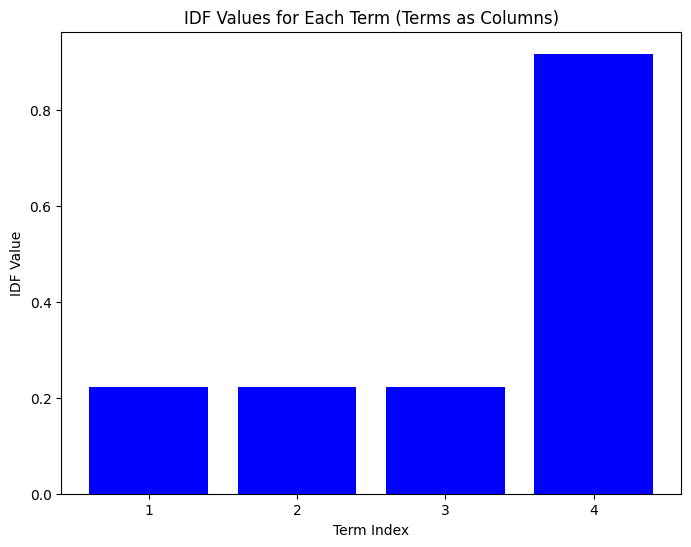

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define the TF matrix as a tensor with rows as documents and columns as terms
tf_matrix = np.array([
    [3, 2, 0, 1],
    [0, 3, 1, 2],
    [1, 0, 5, 0],
    [2, 1, 3, 0],
    [2, 6, 3, 0]
])

# Transpose the matrix so that columns represent terms
tf_matrix = tf_matrix.T

# Calculate document frequency (DF)
df = np.count_nonzero(tf_matrix, axis=1)

# Total number of documents
N = tf_matrix.shape[1]

# Compute IDF
idf = np.log(N / df)

# Create a DataFrame to display results
idf_results = pd.DataFrame({
    'Term': range(1, len(idf) + 1),
    'DF': df,
    'IDF': idf
})

# Display the DataFrame
# import ace_tools as tools; tools.display_dataframe_to_user(name="IDF Calculation Results with Terms as Columns", dataframe=idf_results)

# Plot IDF values
plt.figure(figsize=(8, 6))
plt.bar(range(len(idf)), idf, color='blue')
plt.xlabel('Term Index')
plt.ylabel('IDF Value')
plt.title('IDF Values for Each Term (Terms as Columns)')
plt.xticks(range(len(idf)), range(1, len(idf) + 1))
plt.show()

In [22]:
import torch
import numpy as np

# Sample documents
documents = [
    [2, 2, 3],
    [2, 2],
    [2, 3, 4, 5],
    [3, 5]
]

# Pad documents with None (which we will represent as -1)
max_length = max(len(doc) for doc in documents)
padded_docs = [doc + [-1] * (max_length - len(doc)) for doc in documents]

# Convert to tensor
tensor_docs = torch.tensor(padded_docs)

# Calculate IDF
def calculate_idf(tensor_docs):
    # Flatten the tensor and get unique terms
    unique_terms = torch.unique(tensor_docs[tensor_docs != -1])
    N = tensor_docs.shape[0]  # Number of documents

    idf_scores = []
    for term in unique_terms:
        # Calculate the number of documents containing the term
        term_count = torch.sum((tensor_docs == term), dim=1).clamp(max=1).sum()
        # Compute IDF
        idf = torch.log(torch.tensor(N / (term_count + 1)))
        idf_scores.append(idf)

    idf_tensor = torch.tensor(idf_scores)
    return unique_terms, idf_tensor

unique_terms, idf_scores = calculate_idf(tensor_docs)

# Mapping of terms to their IDF scores
term_idf_mapping = dict(zip(unique_terms.tolist(), idf_scores.tolist()))

term_idf_mapping


KeyboardInterrupt



In [24]:
import torch
from collections import defaultdict
from math import log

# Example list of tensor documents
documents = [
    torch.tensor([1, 2, 3]),
    torch.tensor([1, 2]),
    torch.tensor([2, 3, 4, 5]),
    torch.tensor([3, 5])
]

# Example query
query = torch.tensor([1, 2])

# Find the length of the longest document
max_length = max(doc.size(0) for doc in documents)

# Pad documents with -1 (representing None)
padded_docs = [torch.cat([doc, torch.tensor([-1] * (max_length - doc.size(0)))]) for doc in documents]

# Stack the padded documents into a single tensor
tensor_docs = torch.stack(padded_docs)

# Calculate IDF
def calculate_idf(tensor_docs):
    N = tensor_docs.shape[0]  # Number of documents
    term_doc_count = defaultdict(int)

    for doc in tensor_docs:
        unique_terms = torch.unique(doc[doc != -1])
        for term in unique_terms:
            term_doc_count[term.item()] += 1

    unique_terms = list(term_doc_count.keys())
    idf_scores = [log(N / (term_doc_count[term] + 1)) for term in unique_terms]
    
    idf_tensor = torch.tensor(idf_scores)
    return unique_terms, idf_tensor

# Calculate term frequencies and document lengths
def calculate_tf_and_lengths(tensor_docs):
    tf = defaultdict(lambda: defaultdict(int))
    doc_lengths = []

    for doc_idx, doc in enumerate(tensor_docs):
        doc_length = (doc != -1).sum().item()
        doc_lengths.append(doc_length)

        for term in doc:
            if term != -1:
                tf[term.item()][doc_idx] += 1

    return tf, doc_lengths

# Calculate BM25
def calculate_bm25(tensor_docs, query, k1=1.5, b=0.75):
    unique_terms, idf_scores = calculate_idf(tensor_docs)
    idf_dict = dict(zip(unique_terms, idf_scores.tolist()))
    tf, doc_lengths = calculate_tf_and_lengths(tensor_docs)

    avg_doc_length = sum(doc_lengths) / len(doc_lengths)
    bm25_scores = torch.zeros(tensor_docs.shape[0])

    for term in query:
        if term.item() in idf_dict:
            idf = idf_dict[term.item()]
            for doc_idx in range(tensor_docs.shape[0]):
                tf_term_doc = tf[term.item()][doc_idx]
                doc_length = doc_lengths[doc_idx]
                numerator = tf_term_doc * (k1 + 1)
                denominator = tf_term_doc + k1 * (1 - b + b * doc_length / avg_doc_length)
                bm25_scores[doc_idx] += idf * numerator / denominator

    return bm25_scores

bm25_scores = calculate_bm25(tensor_docs, query)

bm25_scores


tensor([0.2764, 0.3279, 0.0000, 0.0000])

In [35]:
import random
import string

# Sample document collection
documents = {
    1: "The quick brown fox jumps over the lazy dog",
    2: "The quick red fox leaped over the lazy cat",
    3: "Lazy dogs and quick cats"
}

from tqdm.notebook import tqdm

def generate_random_string(length):
    characters = string.ascii_letters + string.digits + string.punctuation
    random_string = ''.join(random.choices(characters, k=length))
    return random_string

documents = {}
for i in tqdm(range(10000)):
    documents[i] = generate_random_string(100000)
len(documents), documents[0]

  0%|          | 0/10000 [00:00<?, ?it/s]

(10000,
 '@z[}A)hMmUPtw1PinTeVuLwd@8V=v=98:t#DkL$IB?VBA?MRbOg[qE=41j@huz\'sPMw]EWL1YJ5:^Vr;@o{>@#@cx9>N~D=3b46h?Gejv55:S"mbjNu2c&oP*#mA0<pHL.%("~}5%=i7sB``u<x#^:)9M/7`(rjeD]@0v7ifCBgi2nb{fiX^cFAnVrJ3|KM<=a(b!I6W0B%By.KI$J|JnV[T}&&W\\WMazob:G@2!J%R{$.xRr{A<j_c)tD#XJdN%;^2C0@;m7qOOH5cNq@lf[,!-)89JlB8,H>4YJ6>\\Z7!*CK1Z[bVjCDU+SI>EE,dKq9.h{(<#P0H%:Tu;#BeL*^7aAb7Hl~4<U=rEM$wvP)6qFvNaIS&/:vW}nBG79y|0o/1"Xr%KTW;gMiT+9Xb~K^eWD~[zUmMqD_Wj(<s3(2K_AH3%1__}8(!c)NDkr:1s:Rm-etjnP?n9z69#vTo{(N<D]=W_mX\'2,IXc+xO:#=[gU8EeJT;ooU8@*Mpdn~5.+mP98;ak|[GjW)r!`oRhH=2()Pw%>oZ9l#)@!TSqV<AGff)C==j2&}H\'NQ1#Ma_*6:gm.H6EgCx\\7G:LW\'Ab`h#8lY"}]:Y\\UOdp8{S-2}8pJEuQuQ&4vUpLnpCwCHt0$Dc7A\\14.j!sU%Y*qJZ<7Y,)FgyOB*g6silW89=hA+9#8$6^ZnJC3%S-bM`S>s|hX4"D,v\'i%B!hyZa0u0Wf^"z\'r/H[8sGXT(`\'vqrZ\\s88^YO<,M35>1a]y<\'tuBKra-TEjysrMg!BsFn]4bb;s}@HUlf}c2*j\'p}Txr2UIL.Zi|8NkQI"05C25g:X7CV9"yHvZ;ejQ01e.*hcK2[~tYg/p4B@KlIL_cU^#\'0YY$V6\\"X,xCx?XOHAwLeh<YP#z<oiy+Djte~RZH"jZFG/W)<lxf`qBS)5@-Xme}?Wo_,/={P`R/-Xs&qgE/fDF:GZ{p{J4,FqNXNQ4

In [34]:
from collections import defaultdict, Counter
import string
import math
import random

# Function to normalize text
def normalize(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator).lower().split()

# Create the reversed index and compute term frequencies
reversed_index = defaultdict(list)
term_frequencies = defaultdict(Counter)
document_frequencies = Counter()

for doc_id, text in documents.items():
    terms = normalize(text)
    term_frequencies[doc_id] = Counter(terms)
    for term in set(terms):
        reversed_index[term].append(doc_id)
        document_frequencies[term] += 1

# Total number of documents
N = len(documents)

# step 2
# BM25 Parameters
k1 = 1.5
b = 0.75

# Compute average document length
avg_doc_len = sum(len(normalize(doc)) for doc in documents.values()) / N

def bm25_score(query, doc_id):
    score = 0.0
    doc_len = sum(term_frequencies[doc_id].values())
    
    for term in query:
        if term in term_frequencies[doc_id]:
            tf = term_frequencies[doc_id][term]
            df = document_frequencies[term]
            idf = math.log((N - df + 0.5) / (df + 0.5) + 1)
            score += idf * ((tf * (k1 + 1)) / (tf + k1 * (1 - b + b * (doc_len / avg_doc_len))))
    
    return score

# Example query
query = normalize("quick fox")

# Calculate BM25 scores for each document
bm25_scores = {doc_id: bm25_score(query, doc_id) for doc_id in documents.keys()}

# Display the BM25 scores
bm25_scores

# step 3
# BM25 Parameters
k1 = 1.5
b = 0.75

# Compute average document length
avg_doc_len = sum(len(normalize(doc)) for doc in documents.values()) / N

def bm25_score(query, doc_id):
    score = 0.0
    doc_len = sum(term_frequencies[doc_id].values())
    
    for term in query:
        if term in tqdm(term_frequencies[doc_id]):
            tf = term_frequencies[doc_id][term]
            df = document_frequencies[term]
            idf = math.log((N - df + 0.5) / (df + 0.5) + 1)
            score += idf * ((tf * (k1 + 1)) / (tf + k1 * (1 - b + b * (doc_len / avg_doc_len))))
    
    return score

# Example query
query = normalize("quick fox")

# Calculate BM25 scores for each document
bm25_scores = {doc_id: bm25_score(query, doc_id) for doc_id in documents.keys()}

# Display the BM25 scores
bm25_scores

KeyboardInterrupt: 

In [28]:
import random
import string
from tqdm.notebook import tqdm

def generate_random_string(length):
    characters = string.ascii_letters + string.digits + string.punctuation
    random_string = ''.join(random.choices(characters, k=length))
    return random_string

documents = {}
for i in tqdm(range(10000)):
    documents[i] = generate_random_string(100000)
print(documents)

  0%|          | 0/1000000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
from collections import defaultdict
import math

class InvertedIndex:
    def __init__(self):
        self.index = defaultdict(list)
        self.doc_lengths = defaultdict(int)
        self.avg_doc_length = 0
        self.N = 0  # Total number of documents

    def add_document(self, doc_id, text):
        terms = text.split()
        term_freq = defaultdict(int)
        
        for term in terms:
            term_freq[term] += 1
            self.doc_lengths[doc_id] += 1
        
        for term, freq in term_freq.items():
            self.index[term].append((doc_id, freq))
        
        self.N += 1
        self.avg_doc_length += len(terms)
    
    def finalize(self):
        self.avg_doc_length /= self.N

    def bm25(self, query, k1=1.5, b=0.75):
        query_terms = query.split()
        scores = defaultdict(float)
        
        for term in query_terms:
            if term not in self.index:
                continue
            
            n_qi = len(self.index[term])
            idf = math.log(1 + (self.N - n_qi + 0.5) / (n_qi + 0.5))
            
            for doc_id, freq in self.index[term]:
                tf = freq
                doc_length = self.doc_lengths[doc_id]
                score = idf * ((tf * (k1 + 1)) / (tf + k1 * (1 - b + b * (doc_length / self.avg_doc_length))))
                scores[doc_id] += score
        
        return sorted(scores.items(), key=lambda item: item[1], reverse=True)

# Example usage
docs = [
    "the quick brown fox",
    "jumped over the lazy dog",
    "lorem ipsum dolor sit amet",
    "the quick brown fox jumped over the lazy dog",
]

index = InvertedIndex()

for i, doc in enumerate(docs):
    index.add_document(i, doc)

index.finalize()
query = "quick brown"
results = index.bm25(query)

print("BM25 results:", results)

KeyboardInterrupt: 